In [47]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from ml.utils import *
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

%matplotlib inline

In [48]:
Tx = 11998 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 2996 # The number of time steps in the output of our model
LEN = 20000

In [49]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

background len: 10000
activate[0] len: 413
activate[1] len: 298


In [50]:
len(activates), len(negatives)

(63, 43)

In [51]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    segment_start = np.random.randint(low=0, high=LEN-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [52]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [53]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [54]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    n_attempts = 20
    while n_attempts > 0:
        segment_time = get_random_time_segment(segment_ms)
        if not is_overlapping(segment_time, previous_segments):
            break
        n_attempts -= 1
    else:
        raise Exception
    

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [55]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, start_ms, end_ms):
    # duration of the background (in terms of spectrogram time-steps)
    start_y = int(start_ms * Ty / LEN)
    end_y = int(end_ms * Ty / LEN)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(start_y + 1, end_y + 1):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [56]:
def insert_audio(background, audio_clip, ts):
    new_background = background.overlay(audio_clip, position = ts)
    
    return new_background

In [57]:
# GRADED FUNCTION: create_training_example

def create_training_example(backgrounds, activates, negatives, index=None):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
#     np.random.seed(index or 18)
    
    # Make background quieter
    background = backgrounds[np.random.choice(len(backgrounds), 1)[0]]
    background = background + background
#     background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    ts = np.random.randint(100, 700)
    max_prob = np.random.rand(1) * 0.4 + 0.2
    while ts < LEN:
        prob = np.random.rand(1)
        if prob < max_prob:
            word = activates[np.random.choice(range(len(activates)))]
            y = insert_ones(y, start_ms=ts, end_ms=ts + len(word))
        else:
            word = negatives[np.random.choice(range(len(negatives)))]
        background = insert_audio(background, word, ts)
        ts += len(word) + np.random.randint(100, 700)

    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    filename = "ml/generated/train" + str(index) + ".wav"
    file_handle = background.export(filename, format="wav")
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x, data, rate, bins = graph_spectrogram(filename)
    
    return x, y

In [58]:
len(activates)

63

In [59]:
x, y = create_training_example(backgrounds, activates, negatives)


In [60]:
IPython.display.Audio("ml/generated/trainNone.wav")

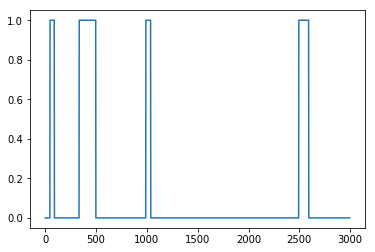

In [61]:
plt.plot(y[0])

In [62]:
from tqdm import tqdm

def get_data(size, directory):
    X_list, Y_list = [], []

    for i in tqdm(range(size)):
#     for i in range(size):
        while True:
            try:
                x, y = create_training_example(backgrounds, activates, negatives, i)
                if x.shape != (101, 11998):
                    raise Exception
                break
            except Exception:
                i -= 1
                continue
        X_list.append(x)
        Y_list.append(y)

    X = np.asarray(X_list)
    Y = np.asarray(Y_list)
    X_sw = np.swapaxes(X, 1, 2)
    Y_sw = np.swapaxes(Y, 1, 2)
    
    with open(directory + '/X.npy', 'wb') as outfile:
        np.save(outfile, X_sw)
    with open(directory + '/Y.npy', 'wb') as outfile:
        np.save(outfile, Y_sw)
    
    return X_sw, Y_sw

In [63]:
train_size = 1000
test_size = 100

get_data(train_size, 'ml/train')
X_sw, Y_sw = get_data(test_size, 'ml/test')




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<02:53,  5.75it/s]


  0%|          | 2/1000 [00:00<02:54,  5.71it/s]


  0%|          | 3/1000 [00:00<02:54,  5.70it/s]


  0%|          | 4/1000 [00:00<02:48,  5.91it/s]


  0%|          | 5/1000 [00:00<02:44,  6.06it/s]


  1%|          | 6/1000 [00:01<05:45,  2.88it/s]


  1%|          | 7/1000 [00:02<05:58,  2.77it/s]


  1%|          | 8/1000 [00:02<04:59,  3.31it/s]


  1%|          | 9/1000 [00:02<04:25,  3.73it/s]


  1%|          | 10/1000 [00:02<03:56,  4.18it/s]


  1%|          | 11/1000 [00:02<03:31,  4.68it/s]


  1%|          | 12/1000 [00:03<04:37,  3.56it/s]


  1%|▏         | 13/1000 [00:03<04:06,  4.00it/s]


  1%|▏         | 14/1000 [00:03<03:40,  4.47it/s]


  2%|▏         | 15/1000 [00:03<03:22,  4.87it/s]


  2%|▏         | 16/1000 [00:03<03:13,  5.10it/s]


  2%|▏         | 17/1000 [00:03<03:01,  5.40it/s]


  2%|▏         | 18/1000 [00:04<02:55,  5.58it/s]


  2%|▏         | 19/1000 [0

 13%|█▎        | 134/1000 [00:34<03:33,  4.05it/s]


 14%|█▎        | 135/1000 [00:35<04:43,  3.05it/s]


 14%|█▎        | 136/1000 [00:35<04:08,  3.48it/s]


 14%|█▎        | 137/1000 [00:35<03:42,  3.88it/s]


 14%|█▍        | 138/1000 [00:35<03:19,  4.33it/s]


 14%|█▍        | 139/1000 [00:36<03:03,  4.70it/s]


 14%|█▍        | 140/1000 [00:36<02:53,  4.96it/s]


 14%|█▍        | 141/1000 [00:36<04:11,  3.42it/s]


 14%|█▍        | 142/1000 [00:37<05:12,  2.75it/s]


 14%|█▍        | 143/1000 [00:37<05:30,  2.60it/s]


 14%|█▍        | 144/1000 [00:37<04:33,  3.13it/s]


 14%|█▍        | 145/1000 [00:38<03:48,  3.74it/s]


 15%|█▍        | 146/1000 [00:38<03:21,  4.24it/s]


 15%|█▍        | 147/1000 [00:38<03:00,  4.73it/s]


 15%|█▍        | 148/1000 [00:38<02:43,  5.22it/s]


 15%|█▍        | 149/1000 [00:38<03:39,  3.87it/s]


 15%|█▌        | 150/1000 [00:39<03:12,  4.41it/s]


 15%|█▌        | 151/1000 [00:39<02:58,  4.75it/s]


 15%|█▌        | 152/1000 [00:39<03:54,  3.61i

 27%|██▋       | 266/1000 [01:03<02:27,  4.99it/s]


 27%|██▋       | 267/1000 [01:03<02:30,  4.87it/s]


 27%|██▋       | 268/1000 [01:04<02:30,  4.87it/s]


 27%|██▋       | 269/1000 [01:04<02:29,  4.90it/s]


 27%|██▋       | 270/1000 [01:04<02:28,  4.93it/s]


 27%|██▋       | 271/1000 [01:04<02:29,  4.87it/s]


 27%|██▋       | 272/1000 [01:04<02:32,  4.77it/s]


 27%|██▋       | 273/1000 [01:06<07:55,  1.53it/s]


 27%|██▋       | 274/1000 [01:07<07:05,  1.71it/s]


 28%|██▊       | 275/1000 [01:07<05:29,  2.20it/s]


 28%|██▊       | 276/1000 [01:07<04:23,  2.75it/s]


 28%|██▊       | 277/1000 [01:07<03:34,  3.37it/s]


 28%|██▊       | 278/1000 [01:07<04:06,  2.93it/s]


 28%|██▊       | 279/1000 [01:08<03:25,  3.51it/s]


 28%|██▊       | 280/1000 [01:08<04:03,  2.95it/s]


 28%|██▊       | 281/1000 [01:08<03:19,  3.61it/s]


 28%|██▊       | 282/1000 [01:08<02:52,  4.17it/s]


 28%|██▊       | 283/1000 [01:09<05:07,  2.33it/s]


 28%|██▊       | 284/1000 [01:09<04:07,  2.90i

 40%|███▉      | 398/1000 [01:43<01:58,  5.07it/s]


 40%|███▉      | 399/1000 [01:44<04:24,  2.27it/s]


 40%|████      | 400/1000 [01:44<03:36,  2.78it/s]


 40%|████      | 401/1000 [01:44<03:01,  3.31it/s]


 40%|████      | 402/1000 [01:45<03:56,  2.53it/s]


 40%|████      | 403/1000 [01:45<03:17,  3.02it/s]


 40%|████      | 404/1000 [01:45<02:50,  3.50it/s]


 40%|████      | 405/1000 [01:46<03:33,  2.78it/s]


 41%|████      | 406/1000 [01:46<03:01,  3.28it/s]


 41%|████      | 407/1000 [01:46<02:35,  3.80it/s]


 41%|████      | 408/1000 [01:47<04:30,  2.19it/s]


 41%|████      | 409/1000 [01:47<03:36,  2.73it/s]


 41%|████      | 410/1000 [01:47<02:57,  3.32it/s]


 41%|████      | 411/1000 [01:47<02:31,  3.88it/s]


 41%|████      | 412/1000 [01:48<02:12,  4.43it/s]


 41%|████▏     | 413/1000 [01:48<01:59,  4.91it/s]


 41%|████▏     | 414/1000 [01:48<03:18,  2.95it/s]


 42%|████▏     | 415/1000 [01:49<02:45,  3.52it/s]


 42%|████▏     | 416/1000 [01:49<02:24,  4.03i

 53%|█████▎    | 530/1000 [02:20<01:27,  5.35it/s]


 53%|█████▎    | 531/1000 [02:20<01:29,  5.24it/s]


 53%|█████▎    | 532/1000 [02:20<01:30,  5.18it/s]


 53%|█████▎    | 533/1000 [02:20<01:27,  5.34it/s]


 53%|█████▎    | 534/1000 [02:20<01:30,  5.17it/s]


 54%|█████▎    | 535/1000 [02:21<01:30,  5.15it/s]


 54%|█████▎    | 536/1000 [02:21<01:30,  5.12it/s]


 54%|█████▎    | 537/1000 [02:21<01:33,  4.93it/s]


 54%|█████▍    | 538/1000 [02:22<03:52,  1.99it/s]


 54%|█████▍    | 539/1000 [02:22<03:04,  2.49it/s]


 54%|█████▍    | 540/1000 [02:22<02:29,  3.08it/s]


 54%|█████▍    | 541/1000 [02:23<02:06,  3.63it/s]


 54%|█████▍    | 542/1000 [02:23<02:33,  2.98it/s]


 54%|█████▍    | 543/1000 [02:23<02:07,  3.58it/s]


 54%|█████▍    | 544/1000 [02:23<01:49,  4.18it/s]


 55%|█████▍    | 545/1000 [02:24<01:36,  4.74it/s]


 55%|█████▍    | 546/1000 [02:24<01:26,  5.23it/s]


 55%|█████▍    | 547/1000 [02:24<01:24,  5.39it/s]


 55%|█████▍    | 548/1000 [02:24<01:19,  5.69i

 66%|██████▌   | 662/1000 [02:53<01:03,  5.36it/s]


 66%|██████▋   | 663/1000 [02:53<01:00,  5.54it/s]


 66%|██████▋   | 664/1000 [02:53<00:57,  5.83it/s]


 66%|██████▋   | 665/1000 [02:54<01:33,  3.58it/s]


 67%|██████▋   | 666/1000 [02:54<01:22,  4.06it/s]


 67%|██████▋   | 667/1000 [02:54<01:13,  4.50it/s]


 67%|██████▋   | 668/1000 [02:54<01:05,  5.04it/s]


 67%|██████▋   | 669/1000 [02:55<01:53,  2.91it/s]


 67%|██████▋   | 670/1000 [02:55<01:35,  3.45it/s]


 67%|██████▋   | 671/1000 [02:55<01:23,  3.92it/s]


 67%|██████▋   | 672/1000 [02:56<01:15,  4.36it/s]


 67%|██████▋   | 673/1000 [02:56<01:07,  4.87it/s]


 67%|██████▋   | 674/1000 [02:56<01:01,  5.31it/s]


 68%|██████▊   | 675/1000 [02:56<00:57,  5.67it/s]


 68%|██████▊   | 676/1000 [02:56<00:54,  5.99it/s]


 68%|██████▊   | 677/1000 [02:56<00:51,  6.23it/s]


 68%|██████▊   | 678/1000 [02:56<00:50,  6.40it/s]


 68%|██████▊   | 679/1000 [02:57<00:50,  6.33it/s]


 68%|██████▊   | 680/1000 [02:57<01:11,  4.47i

 79%|███████▉  | 794/1000 [03:21<00:48,  4.24it/s]


 80%|███████▉  | 795/1000 [03:21<01:02,  3.26it/s]


 80%|███████▉  | 796/1000 [03:22<01:11,  2.86it/s]


 80%|███████▉  | 797/1000 [03:22<00:58,  3.44it/s]


 80%|███████▉  | 798/1000 [03:22<00:51,  3.96it/s]


 80%|███████▉  | 799/1000 [03:22<00:45,  4.40it/s]


 80%|████████  | 800/1000 [03:22<00:41,  4.81it/s]


 80%|████████  | 801/1000 [03:23<01:10,  2.83it/s]


 80%|████████  | 802/1000 [03:23<00:58,  3.39it/s]


 80%|████████  | 803/1000 [03:23<00:50,  3.91it/s]


 80%|████████  | 804/1000 [03:24<00:43,  4.47it/s]


 80%|████████  | 805/1000 [03:24<00:56,  3.47it/s]


 81%|████████  | 806/1000 [03:24<01:04,  3.02it/s]


 81%|████████  | 807/1000 [03:25<00:54,  3.55it/s]


 81%|████████  | 808/1000 [03:25<00:47,  4.04it/s]


 81%|████████  | 809/1000 [03:25<00:42,  4.46it/s]


 81%|████████  | 810/1000 [03:25<00:39,  4.83it/s]


 81%|████████  | 811/1000 [03:25<00:36,  5.19it/s]


 81%|████████  | 812/1000 [03:25<00:34,  5.40i

 93%|█████████▎| 926/1000 [03:50<00:13,  5.34it/s]


 93%|█████████▎| 927/1000 [03:50<00:13,  5.47it/s]


 93%|█████████▎| 928/1000 [03:50<00:12,  5.68it/s]


 93%|█████████▎| 929/1000 [03:50<00:12,  5.92it/s]


 93%|█████████▎| 930/1000 [03:50<00:11,  6.04it/s]


 93%|█████████▎| 931/1000 [03:51<00:11,  6.20it/s]


 93%|█████████▎| 932/1000 [03:51<00:10,  6.22it/s]


 93%|█████████▎| 933/1000 [03:51<00:10,  6.31it/s]


 93%|█████████▎| 934/1000 [03:51<00:10,  6.39it/s]


 94%|█████████▎| 935/1000 [03:51<00:16,  4.01it/s]


 94%|█████████▎| 936/1000 [03:52<00:14,  4.56it/s]


 94%|█████████▎| 937/1000 [03:52<00:12,  5.05it/s]


 94%|█████████▍| 938/1000 [03:52<00:11,  5.37it/s]


 94%|█████████▍| 939/1000 [03:52<00:10,  5.62it/s]


 94%|█████████▍| 940/1000 [03:53<00:21,  2.86it/s]


 94%|█████████▍| 941/1000 [03:53<00:17,  3.41it/s]


 94%|█████████▍| 942/1000 [03:53<00:14,  3.96it/s]


 94%|█████████▍| 943/1000 [03:53<00:12,  4.44it/s]


 94%|█████████▍| 944/1000 [03:53<00:11,  4.91i

 59%|█████▉    | 59/100 [00:12<00:11,  3.57it/s]


 60%|██████    | 60/100 [00:12<00:09,  4.15it/s]


 61%|██████    | 61/100 [00:12<00:08,  4.72it/s]


 62%|██████▏   | 62/100 [00:12<00:07,  5.17it/s]


 63%|██████▎   | 63/100 [00:13<00:09,  3.99it/s]


 64%|██████▍   | 64/100 [00:13<00:07,  4.60it/s]


 65%|██████▌   | 65/100 [00:13<00:06,  5.09it/s]


 66%|██████▌   | 66/100 [00:13<00:06,  5.49it/s]


 67%|██████▋   | 67/100 [00:13<00:05,  5.74it/s]


 68%|██████▊   | 68/100 [00:13<00:05,  5.96it/s]


 69%|██████▉   | 69/100 [00:14<00:08,  3.83it/s]


 70%|███████   | 70/100 [00:14<00:07,  4.14it/s]


 71%|███████   | 71/100 [00:14<00:06,  4.59it/s]


 72%|███████▏  | 72/100 [00:14<00:05,  4.86it/s]


 73%|███████▎  | 73/100 [00:15<00:07,  3.44it/s]


 74%|███████▍  | 74/100 [00:15<00:06,  3.93it/s]


 75%|███████▌  | 75/100 [00:15<00:05,  4.34it/s]


 76%|███████▌  | 76/100 [00:15<00:05,  4.66it/s]


 77%|███████▋  | 77/100 [00:16<00:04,  4.77it/s]


 78%|███████▊  | 78/100 [00:16<